In [4]:
%matplotlib inline
import math
import scipy.io
import os
from os.path import isfile, join
import numpy as np
from matplotlib import pyplot as plt
from scipy import signal
import pandas as pd
from scipy.fftpack import fft, ifft
from sklearn import metrics
#import seaborn as sns
import PyOctaveBand

In [1]:
mypath = '20220823_10mm'
# mypath= '20210729_manual_5mmtip'
start_with = 'SI_CH'#for files from 2022
# start_with='SI_2MHz'
#start_with = 'SI_2MHz'
label_file = '20220823_Impact_Echo_5mm_und_10mm_hammer.xlsx'
# label_file = '20210729_Impact_Echo_5mm_und_10mm_hammer.xlsx'

In [2]:
# additional functions
def autocorr(x):
    result = np.correlate(x, x, mode='full')
    return result[result.size // 2:]

def NormalizeData(data):
    return (data - np.min(data)) / (np.max(data) - np.min(data))

def PreprocessSignal(fft_signal, L_scaling, filter_type):
    if filter_type != "power":
        P2_test = np.abs(fft_signal/L_scaling)
    else: P2_test = np.abs(fft_signal/L_scaling)**2
    
    P1_test = P2_test[1:L_scaling//2+1]
    P1_test[2:-1] = 2*P1_test[2:-1]
       
    return NormalizeData(P1_test)

In [5]:
# Read labels
mat_label=0

# get correct labels
# for 20220823: Tabelle1 - 5mm; Tabelle2 - 10mm
# for 20210729: Tabelle1 - 10mm; Tabelle2 - 5mm
df_label = pd.read_excel(label_file, sheet_name='Tabelle2')
mat_label=list(df_label['Good = 1/ bad = 0'])

In [6]:
matfiles = [f for f in os.listdir(mypath) if (isfile(join(mypath, f)) and f.endswith(".mat") and 
                                           f.startswith(start_with))]
matfiles.sort()

In [7]:
#search for the index where 1 first time appear
item=1
idx_mat = mat_label.index(item)
idx_mat

51

In [38]:
fft_mean = []
power_mean = []
All_signals = []
All_Y_fft = []
All_Y_oct = []
#All_Y_corr = []
ref_Y_fft = []
ref_Y_oct = []
# = []
Ch=0
f_min = 5000
f_max = 20000
reference=idx_mat#80
tpd_label = []
for k in range(0,len(matfiles)):
    mat = scipy.io.loadmat(mypath+'/'+matfiles[k]) 
    tpd = 'tpd1' if "tpd1" in mat else 'tpd' 
    Fs_scaling = mat[tpd][0]['SampleFrequency'][0][0][0] # Sampling frequency
    T_scaling = 1/Fs_scaling  # Sampling period
    L_scaling = len(mat[tpd][0]['Data'][0][Ch]) # Length of signal
    L_scaling = 6000 # Change Length of signal (ASK )
    f = Fs_scaling*np.arange(0,(L_scaling/2))/L_scaling;

    t = np.arange(0,L_scaling)*T_scaling
    signal_scaling = mat[tpd][0]['Data'][0][Ch]
    
    f_norm = 500/Fs_scaling # 500 Hz highpass filter
    #b, a = signal.butter(2, f_norm, 'high', analog=True) #butterworth filter of second degree
    length_signal_scaling=len(mat[tpd])
    # initialisation

    for i in range(0,length_signal_scaling):
        signal_data = mat[tpd][i]['Data'][0][Ch]
        signal_detrended = signal.detrend(signal_data)
        All_signals.append(signal_detrended)
                
        # 1. -----
        # Extract fft features
        All_Y_fft.append(fft(All_signals[-1])) #FFT of each signal
        # 2. -----
        # Extract octave band features           
        spl, freq = PyOctaveBand.octavefilter(signal_detrended, fs=Fs_scaling, fraction=24, order=6, #fraction=24
                                                  limits=[f_min, f_max], show=0)
        All_Y_oct.append(spl)  
        
        # Extract reference model
        if k>reference: 
            ref_Y_fft.append(fft(All_signals[-1]))
            ref_Y_oct.append(spl)
            
        tpd_label.append(mat_label[k])


In [41]:
#search for the index where 1 first time appear
item=1
index = tpd_label.index(item)
idx_mat=mat_label.index(item)

In [42]:
fft_ref = []
power_ref = []
oct_ref = []
fft_scal=[]
power_scal = []
oct_scal = []
fft_scal_m=[]
power_scal_m = []
oct_scal_m = []
fft_all=[]
power_all = []
oct_all = []
window_size=5
len4ref=120
# reference data without scaling
start_ref = 100
for i in range(start_ref,len4ref-window_size):
    #Y_mean_oct = np.mean(Y_oct,axis=0)
    Y_fft_ref = []
    Y_oct_ref = []
    Y_fft_ref = ref_Y_fft[i:i+window_size]
    Y_oct_ref = ref_Y_oct[i:i+window_size]
    Y_mean_fft_ref = np.mean(Y_fft_ref,axis=0)
    Y_mean_oct_ref = np.mean(Y_oct_ref,axis=0)
    fft_ref.append(PreprocessSignal(Y_mean_fft_ref,L_scaling,'fft')) 
    power_ref.append(PreprocessSignal(Y_mean_fft_ref,L_scaling,'power')) 
    oct_ref.append(PreprocessSignal(Y_mean_oct_ref,L_scaling,'oct'))
    
# scaling in the beginning of the measuraments with max scaling
for i in range(0,len4ref-window_size):
    #Y_mean_oct = np.mean(Y_oct,axis=0)
    Y_fft = []
    Y_oct = []
    Y_fft = All_Y_fft[i:i+window_size]
    Y_oct = All_Y_oct[i:i+window_size]
    Y_mean_fft = np.mean(Y_fft,axis=0)
    Y_mean_oct = np.mean(Y_oct,axis=0)
    fft_scal.append(PreprocessSignal(Y_mean_fft,L_scaling,'fft')) 
    power_scal.append(PreprocessSignal(Y_mean_fft,L_scaling,'power')) 
    oct_scal.append(PreprocessSignal(Y_mean_oct,L_scaling,'oct'))
    
# scaling somewhere in the middle of the measuraments 
start_mid = 900
for i in range(start_mid,start_mid+len4ref-window_size):
    #Y_mean_oct = np.mean(Y_oct,axis=0)
    Y_fft = []
    Y_oct = []
    Y_fft = All_Y_fft[i:i+window_size]
    Y_oct = All_Y_oct[i:i+window_size]
    Y_mean_fft = np.mean(Y_fft,axis=0)
    Y_mean_oct = np.mean(Y_oct,axis=0)
    fft_scal_m.append(PreprocessSignal(Y_mean_fft,L_scaling,'fft')) 
    power_scal_m.append(PreprocessSignal(Y_mean_fft,L_scaling,'power')) 
    oct_scal_m.append(PreprocessSignal(Y_mean_oct,L_scaling,'oct'))
    
# all 
for i in range(0,len(All_Y_fft)-window_size):
    #Y_mean_oct = np.mean(Y_oct,axis=0)
    Y_fft = []
    Y_oct = []
    Y_fft = All_Y_fft[i:i+window_size]
    Y_oct = All_Y_oct[i:i+window_size]
    Y_mean_fft = np.mean(Y_fft,axis=0)
    Y_mean_oct = np.mean(Y_oct,axis=0)
    fft_all.append(PreprocessSignal(Y_mean_fft,L_scaling,'fft')) 
    power_all.append(PreprocessSignal(Y_mean_fft,L_scaling,'power')) 
    oct_all.append(PreprocessSignal(Y_mean_oct,L_scaling,'oct'))

1294
(3000,)
[0.0550195  0.06662486 0.14954118 ... 0.01533091 0.01442849 0.00592863]


IndexError: list index out of range

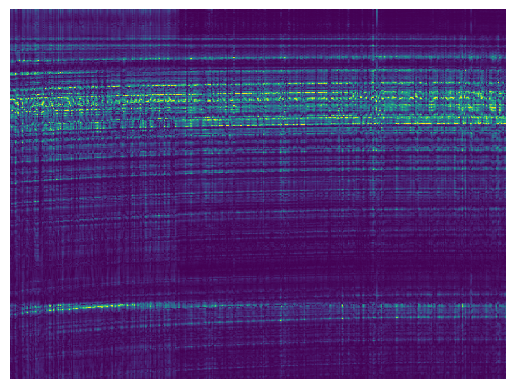

In [43]:
print(len(fft_all)) #all packages
print(fft_all[0].shape)
print(fft_all[0])
# plt.plot(np.arange(0,3000),fft_all[0])
batch_readings=[]
# trial.append(fft_all[0])
# trial.append(np.arange(0,len(fft_all[0])))
# fft_1=list(zip(*fft_all[0]))

mat_index=0
for idx in range(0,51):      
    for i in range(0,21):
        batch_readings.append(fft_all[mat_index])
        mat_index+=1
    plt.axis('off')
    plt.imshow(list(zip(*batch_readings)), interpolation='nearest', aspect='auto')
    file_name="withscale_spec_5mm_manual_ch_1_"+str(idx)+".png"
    plt.savefig(file_name)
    plt.ylim(1700,0)

for idx in range(51,86):
    for i in range(0,21):
        batch_readings.append(fft_all[mat_index])
        mat_index+=1
    plt.axis('off')
    plt.imshow(list(zip(*batch_readings)), interpolation='nearest', aspect='auto')
    file_name="withoutscale_spec_5mm_manual_ch_1_"+str(idx)+".png"
    plt.savefig(file_name)
    plt.ylim(1700,0)
# plt.imshow(trial,aspect='auto')